## Import the required libraries

In [1]:
try:
  # This %tensorflow_version magic only works in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
assert tf.__version__.startswith('1')

tf.enable_eager_execution()

import os
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


## Prepare the training data

First let's download and organize the flowers dataset we'll use to retrain the model (it contains 5 flower classes).

Pay attention to this part so you can reproduce it with your own images dataset. In particular, notice that the "flower_photos" directory contains an appropriately-named directory for each class. The following code then randomizes and divides up all these photos into training and validation sets, and generates the labels file.

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)

flowers_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')


Next, we use [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to rescale the image data into float values (divide by 255 so the tensor values are between 0 and 1), and call `flow_from_directory()` to create two generators: one for the training dataset and one for the validation dataset.


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.



On each iteration, these generators provide a batch of images by reading images from disk and processing them to the proper tensor size (224 x 224). The output is a tuple of (images, labels). For example, you can see the shapes here:

In [5]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

Now save the class labels to a text file:

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('flower_labels.txt', 'w') as f:
  f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [7]:
!cat flower_labels.txt

daisy
dandelion
roses
sunflowers
tulips

## Build the model

Now we'll create a model that's capable of transfer learning on just the last fully-connected layer. 

We'll start with MobileNet V2 from Keras as the base model, which is pre-trained with the ImageNet dataset (trained to recognize 1,000 classes). This provides us a great feature extractor for image classification and we can then simply train a new classification layer with our own dataset.

**Note:** Not all models from [```tf.keras.applications```](https://www.tensorflow.org/api_docs/python/tf/keras/applications) are compatible with the Edge TPU. For details, read about [quantizing Keras models](https://coral.ai/docs/edgetpu/models-intro/#quantizing-keras-models).



### Create the base model 

When instantiating the `MobileNetV2` model, we specify the `include_top=False` argument in order to load the network *without* the classification layers at the top. Then we set `trainable` false to freeze all the weights in the base model. This effectively converts the model into a feature extractor because all the pre-trained weights and biases are preserved in the lower layers when we begin training for our classification head.

In [8]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

### Add a classification head

Now we create a new [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model and pass the frozen MobileNet model from above as the base of the graph, and append new classification layers so we can set the final output dimension to match the number of classes in our dataset (5 types of flowers).

In [12]:
!pip uninstall h5py
!pip install h5py==2.10.0


Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.1 MB/s 


In [9]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=5, activation='softmax')
])

### Configure the model

Although this method is called `compile()`, it's basically a configuration step that's required before we can start training.

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

You can see a string summary of the final network with the `summary()` method:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


And because the majority of the model graph is frozen in the base model, weights from only the last convolution and dense layers are trainable:

In [12]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Train the model


Now we can train the model using data provided by the `train_generator` and `val_generator` we created at the beginning. 

This takes 5-10 minutes to finish.

In [13]:
history = model.fit_generator(train_generator, 
                    epochs=10, 
                    validation_data=val_generator)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
46/46 [==============================] - 28s 607ms/step - loss: 0.9108 - acc: 0.6873 - val_loss: 1.1220 - val_acc: 0.6539
Epoch 2/10
46/46 [==============================] - 22s 473ms/step - loss: 0.4044 - acc: 0.8561 - val_loss: 0.7967 - val_acc: 0.7538
Epoch 3/10
46/46 [==============================] - 22s 474ms/step - loss: 0.2654 - acc: 0.9034 - val_loss: 0.8032 - val_acc: 0.7620
Epoch 4/10
46/46 [==============================] - 22s 476ms/step - loss: 0.2140 - acc: 0.9214 - val_loss: 0.6472 - val_acc: 0.8140
Epoch 5/10
46/46 [==============================] - 23s 491ms/step - loss: 0.1582 - acc: 0.9391 - val_loss: 0.9485 - val_acc: 0.7770
Epoch 6/10
46/46 [==============================] - 22s 484ms/step - loss: 0.1614 - acc: 0.9422 - val_loss: 0.8099 - val_acc: 0.8016
Epoch 7/10
46/46 [==============================] - 22s 480ms/step - loss: 0.1372 - acc: 0.9541 - val_loss: 

### Review the learning curves


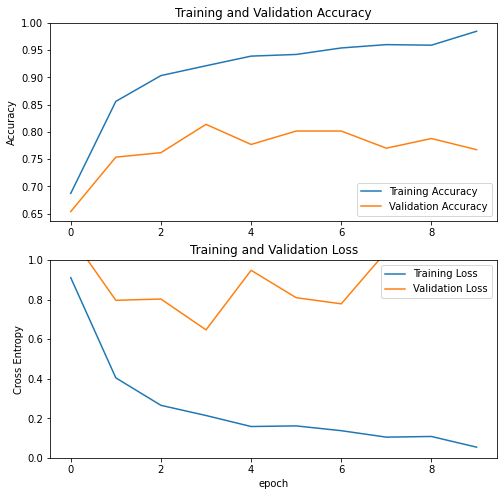

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model


So far, we've only trained the classification layers—the weights of the pre-trained network were *not* changed. The accuracy results aren't bad, but could be better.

One way we can increase the accuracy is to train (or "fine-tune") more layers from the pre-trained model. That is, we'll un-freeze some layers from the base model and adjust those weights (which were originally trained with 1,000 ImageNet classes) so they're better tuned for features found in our flowers dataset.

### Un-freeze more layers


So instead of freezing the entire base model, we'll freeze individual layers.

First, let's see how many layers are in the base model:

In [15]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


Let's try freezing just the bottom 100 layers.

In [16]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Reconfigure the model

Now configure the model again, but this time with a lower training rate (the default is 0.001).

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


In [19]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 60


### Continue training

Now start training all the trainable layers. This starts with the weights we already trained in the classification layers, so we don't need as many epochs.

In [20]:
history_fine = model.fit_generator(train_generator, 
                         epochs=5,
                         validation_data=val_generator)

Epoch 1/5
46/46 [==============================] - 28s 602ms/step - loss: 0.0485 - acc: 0.9857 - val_loss: 1.0774 - val_acc: 0.7811
Epoch 2/5
46/46 [==============================] - 25s 542ms/step - loss: 0.0282 - acc: 0.9935 - val_loss: 0.9712 - val_acc: 0.7811
Epoch 3/5
46/46 [==============================] - 25s 541ms/step - loss: 0.0219 - acc: 0.9969 - val_loss: 0.9122 - val_acc: 0.7921
Epoch 4/5
46/46 [==============================] - 24s 529ms/step - loss: 0.0227 - acc: 0.9959 - val_loss: 0.8795 - val_acc: 0.8126
Epoch 5/5
46/46 [==============================] - 25s 533ms/step - loss: 0.0158 - acc: 0.9980 - val_loss: 0.8263 - val_acc: 0.8181


### Review the new learning curves

Now that we've done some fine-tuning on the MobileNet V2 base model, let's check the accuracy.


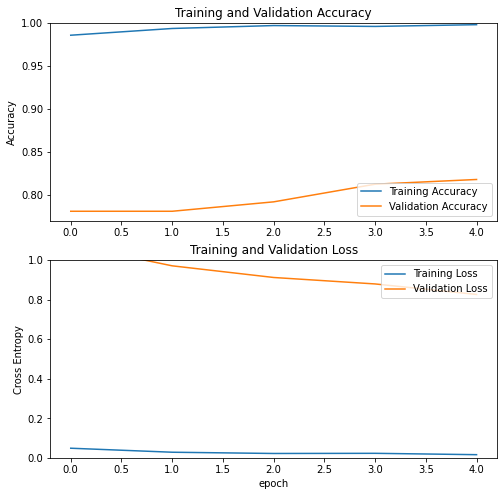

In [21]:
acc = history_fine.history['acc']
val_acc = history_fine.history['val_acc']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This is better, but it's not ideal.

The validation loss is much higher than the training loss, so there could be some overfitting during training. The overfitting might also be because the new training set is relatively small with less intra-class variance, compared to the original ImageNet dataset used to train MobileNet V2.

So this model isn't trained to an accuracy that's production ready, but it works well enough as a demonstration. So let's move on and convert the model to be compatible with the Edge TPU.

In [24]:
saved_keras_model = 'model.h5'
model.save(saved_keras_model)

However, this `.tflite` file isn't compatible with the Edge TPU because although the `DEFAULT` optimizations flag will quantize the weights, the activation values are still in floating-point. So we must fully quantize the model to use int8 format for all parameter data (both weights and activations).

To fully quantize the model, we need to perform [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) with a representative dataset, which requires a few more arguments for the `TFLiteConverter`, and a function that builds a dataset that's representative of the training dataset. 

So let's convert the model again, this time using post-training quantization: